# **Objective and problem statement**
<br>

> ### **The coronavirus: why do we need stricter measures?**
The coronavirus was declared a pandemic by WHO on March 11th, 2020, and by that time, we already had 118,000 confirmed cases and had spread to 114 countries around the globe. Since then, due to a variety of reasons some of which include strict measures not being put into place and government negligence, we have seen these figures blown out of proportions.  Currently, at the time of writing this, we have 13.7 million confirmed cases and near 586,000 deaths worldwide. While some factors can be eluded as being not being under our control as individuals, we cannot say that face masks do not have a big role to play in controlling this pandemic.
<br>
<br>
<br>

> ### - **So, why are masks effective?** 
(***and why is it not a personal choice to wear masks in public places?***)....<br>
Upon wearing the face mask, we as the source of infection reduce the number of droplets ejected by 99 percent according to confirmed studies. It also reduces the intake of number of droplets by an uninfected individual, though not as effective. Yet, if we reduce the number of people getting infected, it also reduces the effective reproduction rate, and hence having an impact of exponential margins.
Nearly half of the infected people do not show symptoms as per recent studies, which can take up to a period of 14 days to appear in an infected individual. Hence, it is really necessary for wearing masks by people in public places, and should really be made mandatory rather than being based on individual decisions, as a significant portion of people with infection lack coronavirus symptoms.
We cannot wait for a controlled trial of a vaccination to be successful for us to be taking all the preventive steps to protect ourselves and others, while contributing to stop the flow of this disease. A successful vaccination won't come till at least the mid of next year, and we cannot ascertain that it would immediately be made publicly available even then by every nation. It can be safely stated that wearing masks is not a personal choice as it can put us and people around us at risk of infection.
<br>


In [ ]:
# Training data for the classification model (Mask vs Without Mask Data)
!gdown --id 1umPOXvITA4nJBiffuKN8NjECidyNr3NY
!unzip /content/Dataset.zip

In [ ]:
# Testing images for mask detection
!gdown --id 1H3anHpuKHOJBfOU_AUZ4vci9IsCeA8Zp
!unzip /content/CrowdMaskDetection.zip 

In [1]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fdet==0.2.1
!pip install youtube-dl
!pip install -U kora
!pip install retina-face

Looking in links: https://download.pytorch.org/whl/torch_stable.html


ERROR: Could not find a version that satisfies the requirement torch==1.4.0+cu100 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu113, 1.11.0+cu115)
ERROR: No matching distribution found for torch==1.4.0+cu100


In [ ]:
# Downloaing testing video (Change the link for testing more videos)
!wget https://media.istockphoto.com/videos/crowd-people-using-mask-video-id1213759078

# **Importing Libraries**

In [1]:
import cv2
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from retinaface import RetinaFace
from IPython.display import HTML

# **Constants**

In [2]:
batch_size = 32
epoch = 2
num_classes = 2
step_per_epoch = len(glob('/content/Dataset/*/*'))//batch_size
image_h, image_w = 128, 128
classes = sorted(['with_mask','without_mask'])


# **Data Collection and Preprocessing**

There were issues circumventing the data collection process, primarily the unavailability of data specific to detecting face masks as detection problem. The images did not have localized bounding boxes, and did not have category labels for the masked and without mask faces of people in the image. Due to this reason, I had to use the approach for face detection and followed by the classification of faces into mask and without mask categories.
<br>

This section can be divided into two parts, with the first part focusing solely on the part of data collection for training examples, followed by the part where I discuss the collection of testing image and video examples. This was done in separate stages to test the proposed approach in a real world crowded setting of people, the use-case for which my algorithm of mask detection is proposed, which would not have been ideal in a setting wherein the training and testing data came from the same source.

<br>

## **1. Data Collection for Training examples**
As discussed earlier, there were various issues which occurred during the collection process for training examples, due to the unavailability of datasets specific to face mask detection. A solution to the same would have been using facial landmarks to detect important indicators for faces, but this idea was not used in our implementation. Finally, it was decided that my best option would be to use a data classified into two categories of images: images of people wearing masks and the ones without mask. It is important to note that the people wearing masks on their face in an incorrect manner would be classified into the "without mask" category. 
<br>
Data collection was done using a variety of sources from interfaces such as Kaggle API and Bing Search. As an additional source, the Real World Masked Face Detection (RMFD) dataset was used to facilitate training of our mask detection algorithm using the classification based approach of detecting masks followed by predicting whether the detected face contains a mask or not.
<br>
The total number of images in the training set were divided into the two categories as follows:

1. With mask: <b>8072 images</b>
2. Without mask: <b>8086 images</b>

<br>

## **2. Data Collection for Inference**
The images and video sequence collected for the purpose of testing our model had to come from a crowded setting to provide a realistic test scenario for my proposed model for mask detection. This task was accomplished using using Google search for images and available YouTube videos for the purpose of scraping the web for realistic examples suited to inference in a real world surveillance setting.
<br>
<br>

# **Reading Image**
- We need to apply transformations on the input image before defining inputs for the model architecture.
- Transformations are done so as to ensure that the inputs to the network are of the right size and respective values sit in a similar range.
- Input image was resized to (128,128) for (height, width) and values in the image tensor were scaled to the range of (-1,1).
- Entire dataset was split into training and test set for cross validation. Split ratio was chose such that 90 percent of the dataset is part of the training set and 10 percent for test set.

In [57]:
def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/127.5-1
  return img

label_map = {v:i for i, v in enumerate(classes)}

images = glob('/content/Dataset/*/*')
np.random.shuffle(images)
print(images)
labels = [label_map[x.split('/')[-2]] for x in images]

(train_images, test_images, train_labels, test_labels) = train_test_split(images, labels,
	test_size=0.10, stratify=labels, random_state=42)

#reading image and label
def load_data(image_path, label):
  image = read_img(image_path)
  return image, label

['/content/Dataset/without_mask/0_0_masu_0213.jpg', '/content/Dataset/without_mask/376.jpg', '/content/Dataset/with_mask/Augmented_846_5887652.png', '/content/Dataset/without_mask/1_0_sunyue_0021.jpg', '/content/Dataset/with_mask/Augmented_668_7716957.png', '/content/Dataset/without_mask/1_0_songxiaofeng_0175.jpg', '/content/Dataset/without_mask/1_0_pengguanying_0015.jpg', '/content/Dataset/with_mask/Augmented_716_6696342.png', '/content/Dataset/with_mask/0_0_8 copy 13.jpg', '/content/Dataset/with_mask/0_0_46.jpg', '/content/Dataset/without_mask/1064.png', '/content/Dataset/without_mask/1_0_pengguanying_0134.jpg', '/content/Dataset/with_mask/Augmented_741_1745629.png', '/content/Dataset/with_mask/Augmented_819_7886690.png', '/content/Dataset/with_mask/with_mask082.jpg', '/content/Dataset/without_mask/1513.png', '/content/Dataset/without_mask/0_0_qiuze_0122.jpg', '/content/Dataset/without_mask/1_0_jiangqinqin_0193.jpg', '/content/Dataset/without_mask/1637.png', '/content/Dataset/with_ma

# **Data Generator**

- Using a data generator, we can batch individual samples into a unified set.
- Data generator spawns processes for loading data to input while training the model.
- This function also provides parallel loading for batches in the training data using shared memory and separate process.


In [6]:
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

#**Visualization of Classification Training Data**

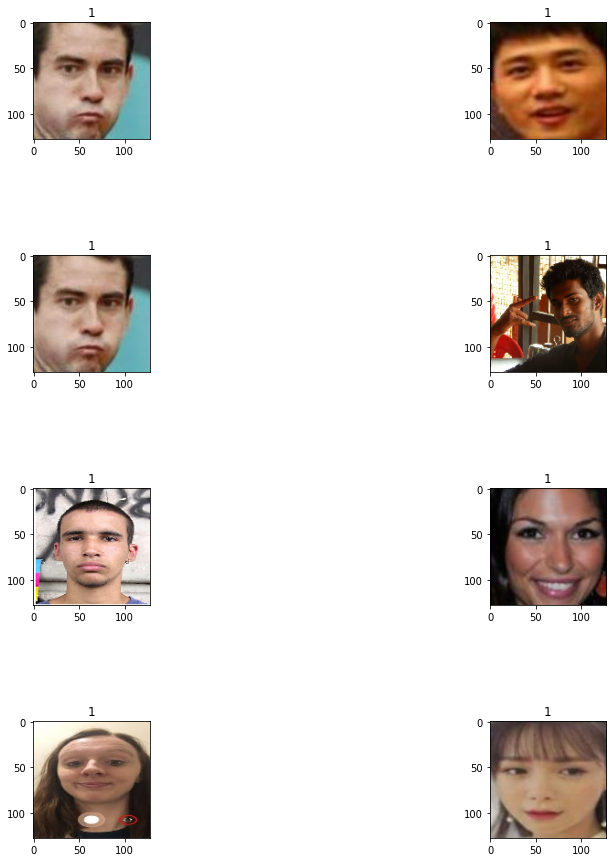

In [7]:
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = (val[0][i]+1)*127.5
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

train_dataset = data_generator(train_images,train_labels)

show_img(train_dataset)


# **Proposed model for Face Mask Detection**
As discussed earlier, the mask detection model can be said to be a combination of classification and face detection model.<br>
For the purpose of classification, we use transfer learning with an Xception model trained on the ImageNet dataset with a modified final fully connected layer. While using the face detection model, several different approaches were tried upon based on existing literature, and the one which worked the best was a RetinaNet Face pre-trained model which gave the highest measures of recall while experimenting on different use-cases and testing images of people in a crowded setting.
<br>
The models and implementation details for them have been discussed in an objective manner as part of this section, and while providing an insight on the approach used (and why it was chosen in the first place), we delve into our final mask detection model which was built using a combination of the classification and face detection models as were briefly described above. 
<br>
## **Model for Classification**: **Xception**
A classification problem is, using available training data with defined features and class labels, build a function which can, with high levels of certainty categorize a new unseen set of data into one of the classes. Having only a limited amount of data available for training the classifier, I was inclined to use transfer learning for the purpose of our task of classifying an input image into the categories of whether the subject is wearing a mask or not. The transfer learning technique is probably one of the most revolutionary ideas to have come out in the past few years, and can be thought of reusing a pre-trained model, which is trained on another set of input images, which in our case would be the use of Xception model trained on the ImageNet database.

#### ***A short introduction to the Xception model***:
It is called an "extreme version of its predecessor Inception V3" for the reason that an efficient use of model parameters by using depth-wise separable convolutions gives better performance on the ImageNet datab. While keeping the number of parameters same in the Inception V3 and Xception model, we ensure that the capacity of the model remains the same but yielding better performance on an almost unparalleled scale, than was achieved using Inception V3 model.
<br>
<br>
Some properties of the Xception model chosen in our case are discussed below:
1. Shape invariance: similar results irrespective of the dimensions of input images (by using Global Avg pooling instaed of flatten) .
2. Removal of final fully connected layer: Prior layers to the final fully connected layer were trained using the weights of Xception trained on the ImageNet database.




In [ ]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)
model.summary()

# **Model fitting**

Implementation details for classification architecture:
- ***Batch Size***: 32 <br>

- ***Epochs***: 2 <br>

- ***Learning rate***: 1e-4 (with decay of 1e-4 / epoch)<br>

- ***Gradient Descent Optimizer***: Adam<br>

- ***Loss function***: Sparse categorical cross entropy<br>

- ***Criterion for evaluation*** (metric): F1-score<br>

In [9]:
#We can use learning rate scheduler here like Cyclical Learning Rate(available in Tf Addons)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4, decay=1e-4 / epoch),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mask_classification_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_dataset,
          batch_size=batch_size,
          epochs=epoch,steps_per_epoch=step_per_epoch,
          callbacks=callbacks)
model.save("model.h5")

Epoch 1/2
504/504 [==============================] - 64s 102ms/step - loss: 0.0390 - accuracy: 0.9870
Epoch 2/2
504/504 [==============================] - 51s 101ms/step - loss: 0.0163 - accuracy: 0.9948


# **Testing the classification model**


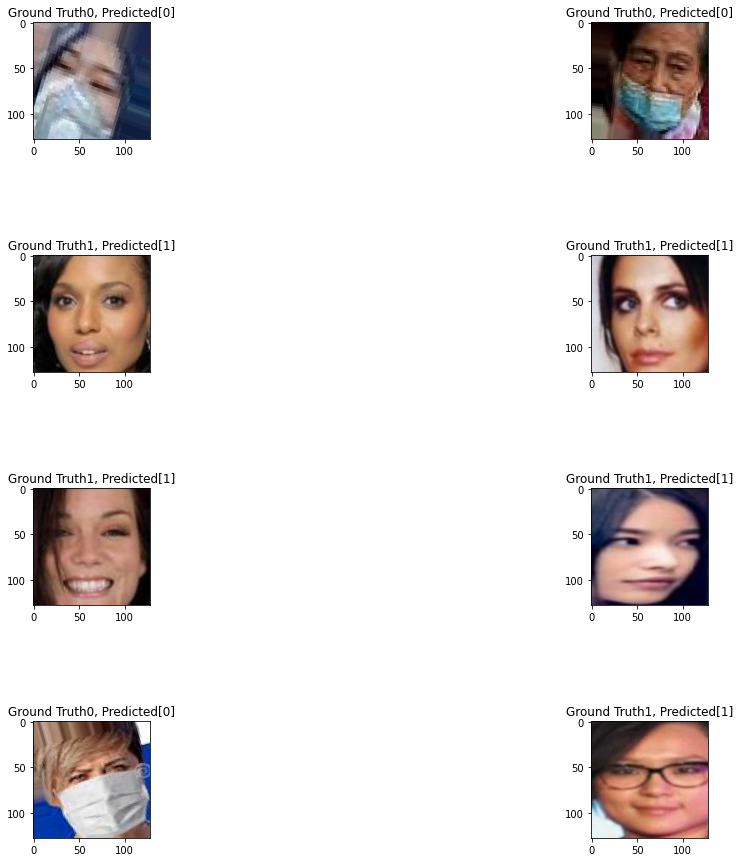

In [10]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in train_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i]+1)*127.5
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

# **Evaluation/Performance Metric**

In [11]:
pred_labels = []
for image_path in (test_images):
  image = read_img(image_path)
  y_pred = model.predict(np.expand_dims(image,axis=0))
  y_pred = np.argmax(y_pred,axis=1)
  pred_labels.append(y_pred)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       807
           1       0.99      0.99      0.99       809

    accuracy                           0.99      1616
   macro avg       0.99      0.99      0.99      1616
weighted avg       0.99      0.99      0.99      1616



# **Face Detection: RetinaNet Face**
Face Detection is the technique of identifying human faces in digital images. While inherently a backbone to other applications, detecting a face is in fact impacted a lot in cluttered scenes, and examples of the same kind of problem can be thought of in a crowded setting, the use-case for which our mask detection algorithm is being built. For this reason, having tried various techniques from classical Computer Vision domain to using deep learning techniques, I needed to prioritize the mAP metric of detected faces in a crowded setting. Having said that, I tried techniques for face detection such as Haar cascading and MT-CNN which did not achieve a high recall. Finally, I sided with a pre-trained RetinaNet Face model, using focal loss which is able to handle the foreground-background class imbalance (an issue with one stage detectors which makes performance of single shot detectors inferior to two stage detectors for object detection) in the detected classes pretty well.

<br>

#### ***An brief overview on the RetinaNet model for object detection:***
- RetinaNet uses focal loss which focuses training on hard negatives, while down-weighting easy examples, using parameters alpha and gamma which provide the hyper-parameters for focusing on hard negatives and offset class imbalance of the number of examples. 
<br>
- As a backbone, the ResNet architecture is used to detect features from input images and a feature pyramid network is used as a fast and multiscale feature extractor on top of this backbone to create a multi-scale pyramid of features. 
<br>
- RetinaNet is able to outperform single stage detectors for object detection such as Single Shot Multibox Detectors, while attaining the accuracy of two stage detectors such as FPN Faster-RCNN with a ResNet-101 backbone.



In [3]:
class_map = {
    0: 'With mask',
    1: 'Without mask'
    }

color_map_video = {
    0: (0,255,0),
    1:(0,0,255)
    }

color_map_image = {
    0: [0,1,0],
    1:[1,0,0]
    }

### **Improving the precision and recall** 

I was able to improve the precision and recall of my model by a high margin in the following ways:
- Resizing the cropped face before providing as input to the classification model.
- For cases wherein the dimensions for height and width of the face crops fall below a threshold, increasing the dimensions of the crop by some proportion.

In [4]:
from keras.models import load_model
model = load_model("classification.h5")
def visualize_detections(image, boxes):
  
  figsize=(7, 7)
  linewidth=1

  image = np.array(image, dtype=np.uint8)

  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)

  ax = plt.gca()

  for box in boxes:
    x, y, w, h = box
    w = w - x
    h = h - y
    face_image = image[y:y+h,x:x+w]

    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:

      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1

      _cls = model.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)
      
      text = '{}'.format(class_map[_cls[0]])

      patch = plt.Rectangle([x, y], w, h, fill=False, 
                            edgecolor=color_map_image[_cls[0]], linewidth=linewidth)
      ax.add_patch(patch)
      ax.text(x, y, text, bbox={'facecolor':color_map_image[_cls[0]], 'alpha':0.2}, 
          clip_box=ax.clipbox, clip_on=True)
  

def visualize_detections_video(image, boxes):
  
  image = np.array(image, dtype=np.uint8)
  
  for box in boxes:
    x, y, w, h = box  
    w = w - x
    h = h - y  
    face_image = image[y:y+h,x:x+w] 
    if w<90 or h<90:
      w = (w*0.5)+w
      h = (h*0.5)+h

    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:
      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1
      
      _cls = model.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)

      text = '{}'.format(class_map[_cls[0]])    
      start = tuple(np.array((x,y)).astype('int'))
      end = tuple(np.array((x+w,y+h)).astype('int'))
      
      cv2.rectangle(image,start,end,color_map_video[_cls[0]],1)
      cv2.putText(image, class_map[_cls[0]], start , cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_map_video[_cls[0]], 1)
  return (image)  



# **Proposed Model for Face Mask Detection:**
On any given test image of a crowd based setting of people, our final mask detection model runs as follows:
Apply the RetinaNet Face model for face detection to generate detected face crops from the input image.
Xception model for classification into mask and no-mask categories for the detected face is applied upon the detections generated by RetinaNet model.
The final output of these two would be the faces detected by RetinaNet along with the predicted category for each face, that is whether the subject is wearing a mask or not.



> ### **Testing on images of densely crowded places**


In [5]:

image_path = '/content/CrowdMaskDetection/*'

for i in glob(image_path):
  image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  
  result = RetinaFace.detect_faces(image)

  boxes = []
  for i in range(len(result)):
    x = "face_" + str(i+1)
    boxes.append(result[x]['facial_area'])
   
  boxes = np.array(boxes)

  visualize_detections(image, boxes)

> ### **Testing on Live videos**

In [7]:
cap = cv2.VideoCapture(0)
img_array = []

while True:
  _, image = cap.read()
  if not _:
    break
  w, h = image.shape[0], image.shape[1] 
  result = RetinaFace.detect_faces(image)
  
  boxes = []
  print(result)
  if(not(isinstance(result, tuple)) ):
        for i in range(len(result)):
            x = "face_" + str(i+1)
            boxes.append(result[x]['facial_area'])
        boxes = np.array(boxes)
        img=visualize_detections_video(image, boxes)
        img_array.append(img)
        cv2.imshow('Video', img)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  

cap.release()
cv2.destroyAllWindows()
 

{'face_1': {'score': 0.9809800982475281, 'facial_area': [253, 185, 542, 479], 'landmarks': {'right_eye': [330.8572, 338.1736], 'left_eye': [470.39932, 368.74014], 'nose': [380.1383, 442.8336], 'mouth_right': [308.056, 473.45316], 'mouth_left': [427.29572, 498.76257]}}}
{'face_1': {'score': 0.9797787666320801, 'facial_area': [234, 186, 525, 479], 'landmarks': {'right_eye': [330.51852, 336.33298], 'left_eye': [466.20038, 367.10602], 'nose': [389.4497, 438.56607], 'mouth_right': [307.88843, 475.49374], 'mouth_left': [421.47076, 500.5618]}}}
{'face_1': {'score': 0.9677620530128479, 'facial_area': [242, 218, 543, 479], 'landmarks': {'right_eye': [331.68057, 328.07147], 'left_eye': [471.74512, 363.59143], 'nose': [379.18555, 435.15613], 'mouth_right': [308.3559, 481.3549], 'mouth_left': [412.77087, 510.59048]}}}
{'face_1': {'score': 0.9748870730400085, 'facial_area': [222, 194, 530, 479], 'landmarks': {'right_eye': [322.55698, 337.88156], 'left_eye': [467.8746, 363.7015], 'nose': [390.15488,

In [ ]:
#For convertng avi to mp4
!ffmpeg -i /content/mask.avi output.mp4

In [ ]:
#You are required to sign in using your Google Id before running this cell

url = upload_public('/content/output.mp4')
HTML(f"""<video src={url} width=500 controls/>""")



# **Results and Discussion**

<br>

> #### *Results obtained on the classification model:*
- ***Loss***: 0.0182
- ***F1 score*** 0.99
<br>

#### ***How does this approach fare in these conditions?***

Using the before mentioned approach of face detection and classification of the detected face crops as wearing a mask or not works pretty well in crowded conditions. This is really important because the use cases for the regions of surveillance may include metropolitan complexes, metro stations and dense marketplaces. These conditions do not provide an ideal scenario for just any face detection algorithm, and it was really necessary that the right choice was made.
> ## **Choice of RetinaNet over MT-CNN, Haar Cascade and HOG:**
- While deciding upon the face detection algorithm to be used as part of my proposed solution of face detection, a pre-trained RetinaNet was chosen as the one which could, with the highest recall and precision, predict the number of faces in a crowded setting.
- In an uncontrolled environment, accurate face localization remains a challenge, and I needed a model which could efficiently predict, with a very high level of certainty- the people who are not wearing a mask in a crowded setting for the mask detection algorithm to work effectively.
- While they work good in general settings, MT-CNN (Multi Task Cascaded Convolutional Neural Network) and classical computer vision algorithms such as Haar Cascade failed to work well in an uncontrolled environment of a crowded setting with people and in dense clusters. RetinaNet with a ResNet backbone and feature pyramid network for feature extraction works even well than some single shot detectors like Single Shot MultiBox Detector and has accuracy on par with two stage detectors like Faster RCNN, and handles foreground-background class imbalance using a modified version of Focal Loss. The class imbalance was the major issue in other single shot detectors, and helps RetinaNet have a lower loss due to easy examples while focusing on hard ones.
- This face detection model 
<u> works well in crowded settings</u>,
 which are bound to have large number of people with 
<u> 'smaller' faces </u> and with varying scale than in a general setting.
<u> On the testing examples, it can be seen that the faces detected vary in scale but are detected with a very high recall and precision.</u>

> ## **Classification model: Choice of architecture**
Transfer learning was employed to use the model weights of the Xception model.<br>
Learning hyperparameters such as learning rate were chosen in an iterative manner, with recommendations taken on choices of values based on available architecture.

>> ### **Criterion for evaluation: F1-score**
>> - F1-score is the harmonic mean of precision and recall. It is chosen as the criterion for evaluation for the classification model. Being bound between 0 and 1, F1-score reaches its best value at 1 and worst at 0.
>> - My model achieves a high F1-score which shows that it can perform well in real world scenarios to classify with certainty, the mask and without mask categories on face crops.
